创建128×128三角形网格并构建邻接图...
网格点数: 16384, 三角形数: 32258
使用METIS分割为20个部分...
分割成功! 切割边数: 1827
网格点数: 16384, 三角形数: 32258
使用METIS分割为20个部分...
分割成功! 切割边数: 1827


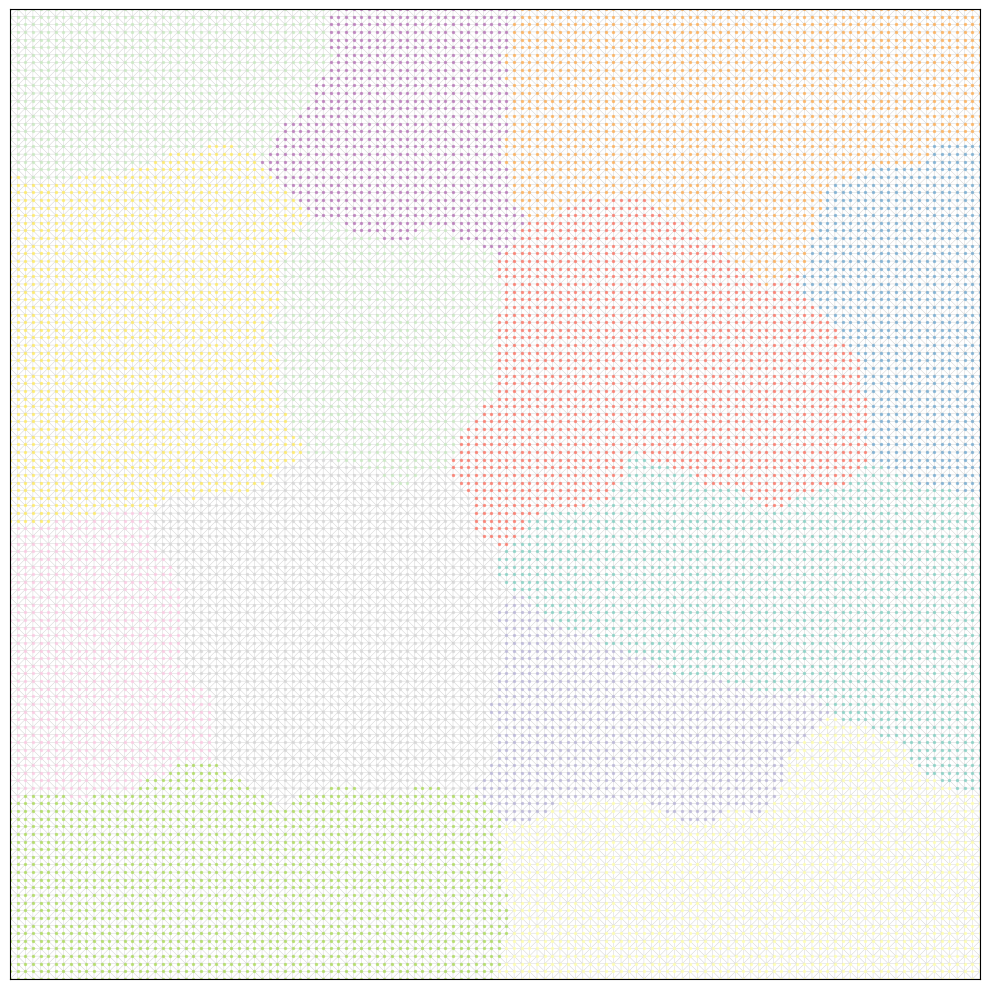


=== 分割统计 ===
总顶点数: 16384, 分区数: 20
平均分区大小: 819.2
分区大小范围: 802 - 836
切割边数: 1827, 切割比例: 0.0376


In [37]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import pymetis
from collections import defaultdict

# 生成[0,1]²区间内的三角形网格
def create_triangular_mesh(n=128):
    """在[0,1]²区间内创建三角形网格"""
    x = np.linspace(0, 1, n)
    y = np.linspace(0, 1, n)
    X, Y = np.meshgrid(x, y)
    points = np.column_stack([X.flatten(), Y.flatten()])
    triangulation = tri.Triangulation(points[:, 0], points[:, 1])
    return points, triangulation

# 构建邻接图
def build_adjacency_from_triangulation(triangulation):
    """从三角剖分构建邻接图"""
    n_vertices = len(triangulation.x)
    adjacency = defaultdict(set)
    
    for triangle in triangulation.triangles:
        for i in range(3):
            for j in range(3):
                if i != j:
                    adjacency[triangle[i]].add(triangle[j])
    
    return [list(adjacency[i]) for i in range(n_vertices)]

# 创建网格和邻接图
print("创建128×128三角形网格并构建邻接图...")
points, triangulation = create_triangular_mesh(128)
adjacency_list = build_adjacency_from_triangulation(triangulation)
n_vertices = len(points)

print(f"网格点数: {n_vertices}, 三角形数: {len(triangulation.triangles)}")

# METIS图分割
n_parts = 20
print(f"使用METIS分割为{n_parts}个部分...")

try:
    cuts, partition = pymetis.part_graph(n_parts, adjacency=adjacency_list)
    print(f"分割成功! 切割边数: {cuts}")
except Exception as e:
    print(f"METIS失败，使用随机分割: {e}")
    partition = np.random.randint(0, n_parts, n_vertices)

partition = np.array(partition)
unique_partitions = np.unique(partition)

# 可视化
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.triplot(triangulation, 'k-', alpha=0.2, linewidth=0.3)

colors = plt.cm.Set3(np.linspace(0, 1, len(unique_partitions)))
for i, part_id in enumerate(unique_partitions):
    mask = partition == part_id
    if np.any(mask):
        ax.scatter(points[mask, 0], points[mask, 1], 
                   c=[colors[i]], s=2, alpha=0.8, 
                   label=f'分区 {part_id}' if i < 10 else '')

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_aspect('equal')
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('')
ax.set_ylabel('')

if len(unique_partitions) <= 10:
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)

plt.tight_layout()
plt.show()

# 统计信息
print(f"\n=== 分割统计 ===")
print(f"总顶点数: {n_vertices}, 分区数: {len(unique_partitions)}")
print(f"平均分区大小: {n_vertices/len(unique_partitions):.1f}")

partition_sizes = np.bincount(partition)
partition_sizes = partition_sizes[partition_sizes > 0]
print(f"分区大小范围: {partition_sizes.min()} - {partition_sizes.max()}")

if 'cuts' in locals():
    total_edges = sum(len(adj) for adj in adjacency_list) // 2
    print(f"切割边数: {cuts}, 切割比例: {cuts/total_edges:.4f}")

创建128×128×128 3D网格并构建邻接图...
3D网格点数: 2097152
使用METIS分割3D网格为16个部分...
3D网格点数: 2097152
使用METIS分割3D网格为16个部分...
3D分割成功! 切割边数: 706743
3D分割成功! 切割边数: 706743


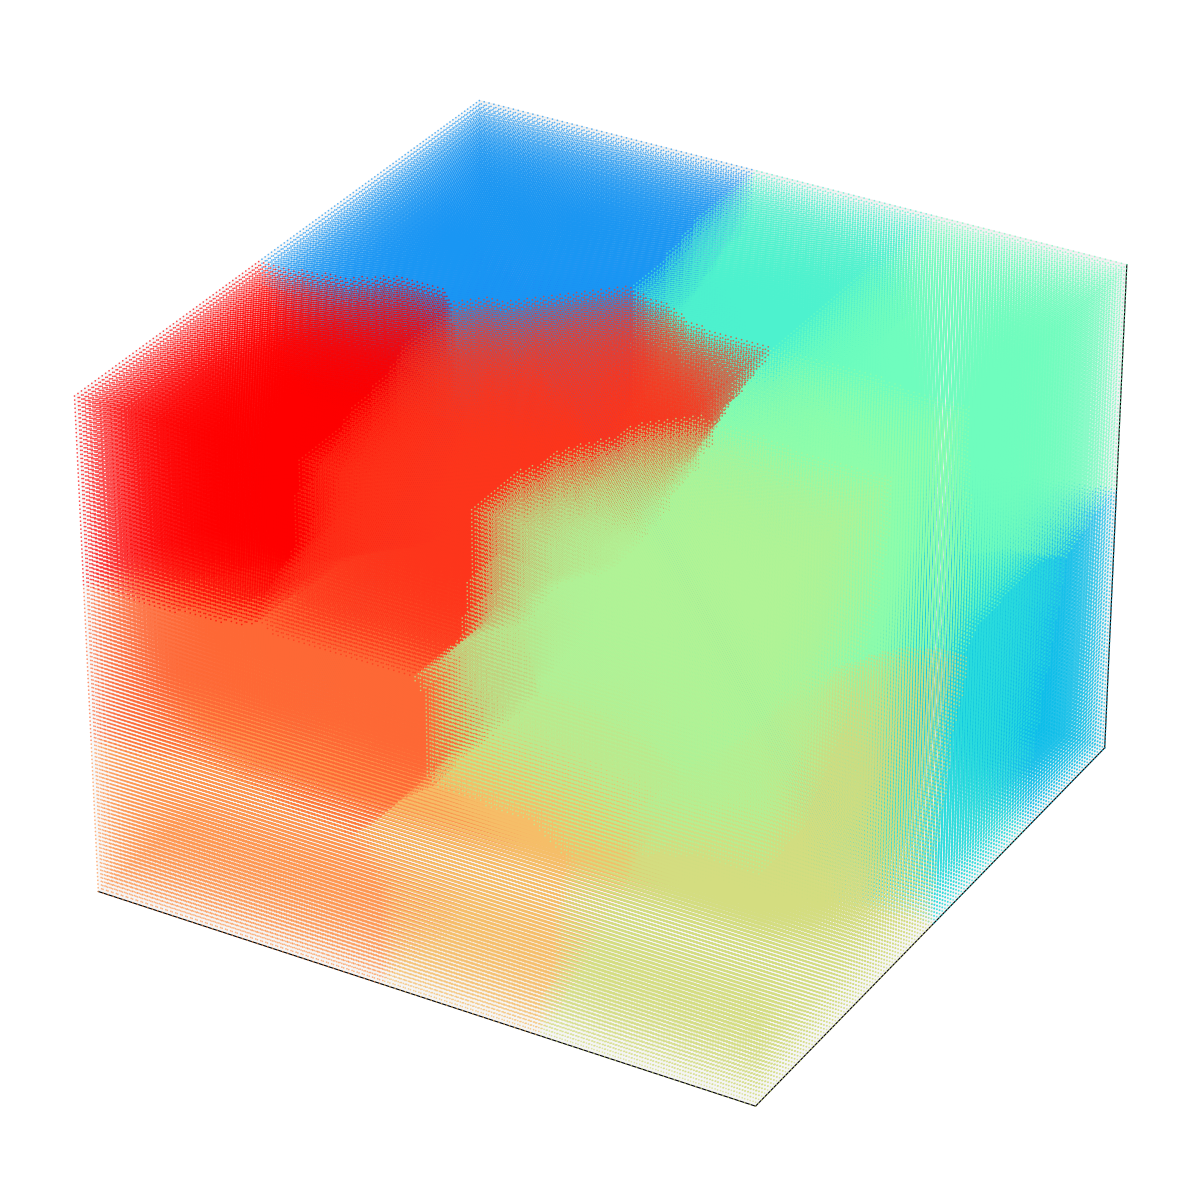


=== 3D分割统计 ===
总顶点数: 2097152, 分区数: 16
平均分区大小: 131072.0
分区大小范围: 131061 - 131079
切割边数: 706743, 切割比例: 0.0263


In [49]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pymetis
from collections import defaultdict

# 生成[0,1]³区间内的3D网格
def create_3d_grid(n=128):
    """在[0,1]³区间内创建3D网格"""
    x = np.linspace(0, 1, n)
    y = np.linspace(0, 1, n)
    z = np.linspace(0, 1, n)
    X, Y, Z = np.meshgrid(x, y, z, indexing='ij')
    points = np.column_stack([X.flatten(), Y.flatten(), Z.flatten()])
    return points

# 构建3D网格的邻接图（26邻域）
def build_3d_adjacency(n=128):
    """构建3D网格的邻接图"""
    adjacency = defaultdict(list)
    
    # 26邻域的偏移量
    offsets = []
    for dx in [-1, 0, 1]:
        for dy in [-1, 0, 1]:
            for dz in [-1, 0, 1]:
                if dx != 0 or dy != 0 or dz != 0:
                    offsets.append((dx, dy, dz))
    
    for i in range(n):
        for j in range(n):
            for k in range(n):
                node_id = i * n * n + j * n + k
                
                for dx, dy, dz in offsets:
                    ni, nj, nk = i + dx, j + dy, k + dz
                    if 0 <= ni < n and 0 <= nj < n and 0 <= nk < n:
                        neighbor_id = ni * n * n + nj * n + nk
                        adjacency[node_id].append(neighbor_id)
    
    return [adjacency[i] for i in range(n**3)]

# 创建3D网格 (使用较小尺寸以节省内存)
n_3d = 128  # 32³ = 32,768个点 (128³会太大)
print(f"创建{n_3d}×{n_3d}×{n_3d} 3D网格并构建邻接图...")
points_3d = create_3d_grid(n_3d)
adjacency_list_3d = build_3d_adjacency(n_3d)
n_vertices_3d = len(points_3d)

print(f"3D网格点数: {n_vertices_3d}")

# METIS 3D图分割
n_parts_3d = 16  # 分割为16个部分
print(f"使用METIS分割3D网格为{n_parts_3d}个部分...")

try:
    cuts_3d, partition_3d = pymetis.part_graph(n_parts_3d, adjacency=adjacency_list_3d)
    print(f"3D分割成功! 切割边数: {cuts_3d}")
except Exception as e:
    print(f"METIS失败，使用随机分割: {e}")
    partition_3d = np.random.randint(0, n_parts_3d, n_vertices_3d)

partition_3d = np.array(partition_3d)
unique_partitions_3d = np.unique(partition_3d)

# 3D可视化 - 渲染所有点
fig = plt.figure(figsize=(15, 12))
ax = fig.add_subplot(111, projection='3d')

# 使用美观的颜色映射 - 彩虹渐变或者鲜艳对比色
import matplotlib.colors as mcolors

# 选择一个漂亮的颜色方案
# 方案1: 使用彩虹色谱
colors_3d = plt.cm.rainbow(np.linspace(0, 1, len(unique_partitions_3d)))

# 或者方案2: 使用鲜艳的对比色（取消注释使用）
# vibrant_colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7', 
#                  '#DDA0DD', '#98D8C8', '#F7DC6F', '#BB8FCE', '#85C1E9',
#                  '#F8C471', '#82E0AA', '#F1948A', '#85C1E9', '#D7BDE2', '#A9DFBF']
# colors_3d = [vibrant_colors[i % len(vibrant_colors)] for i in range(len(unique_partitions_3d))]

# 渲染所有点，使用更小的点和适当的透明度
for i, part_id in enumerate(unique_partitions_3d):
    mask = partition_3d == part_id
    if np.any(mask):
        ax.scatter(points_3d[mask, 0], 
                  points_3d[mask, 1], 
                  points_3d[mask, 2],
                  c=[colors_3d[i]], s=1.5, alpha=0.7, 
                  label=f'分区 {part_id}', edgecolors='none')

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_zlim(0, 1)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_zlabel('')
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
plt.tight_layout()
plt.show()

# 3D统计信息
print(f"\n=== 3D分割统计 ===")
print(f"总顶点数: {n_vertices_3d}, 分区数: {len(unique_partitions_3d)}")
print(f"平均分区大小: {n_vertices_3d/len(unique_partitions_3d):.1f}")

partition_sizes_3d = np.bincount(partition_3d)
partition_sizes_3d = partition_sizes_3d[partition_sizes_3d > 0]
print(f"分区大小范围: {partition_sizes_3d.min()} - {partition_sizes_3d.max()}")

if 'cuts_3d' in locals():
    total_edges_3d = sum(len(adj) for adj in adjacency_list_3d) // 2
    print(f"切割边数: {cuts_3d}, 切割比例: {cuts_3d/total_edges_3d:.4f}")